# QuaNNTO Example — Learning a Cubic-Phase Gate Dataset with Hybrid CV-QONNs

This notebook is an **example script** for the `QuaNNTO` library.

## Goal
Learn a dataset representing the action/statistics of a **non-Gaussian gate** (here: a *cubic phase* operator) using **CV-QONN**s with different the number of optical modes and photon subtractions.

The dataset is assumed to have been **pre-generated** and stored under the configured datasets directory.

---
## What this notebook does
1. Loads a precomputed training dataset: `fock_cubicphase_gamma{gamma}_...`.
2. Trains one CV-QONN per specified configuration using `build_and_train_model`.
3. Evaluates each trained model on the training set (since we do not use a separate validation/test set here).
4. Plots training loss curves for all models.

---
## Notes
- `observable='cubicphase'` is treated as a **special readout mode** in QuaNNTO for this dataset/task.
- This notebook uses QuaNNTO path utilities so results do not depend on the notebook working directory.


In [1]:
import sys
from pathlib import Path

# set repo_root to the parent directory to find 'quannto' modules
repo_root = Path.cwd().resolve().parent  
sys.path.insert(0, str(repo_root))

In [2]:
from functools import partial
import numpy as np

from quannto.core.qnn_trainers import *
from quannto.utils.path_utils import datasets_dir, models_testing_results_path, models_train_losses_path
from quannto.utils.results_utils import *
from quannto.core.data_processors import *
from quannto.core.loss_functions import *

np.random.seed(42)


2026-02-19 22:49:09.224875: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:9261] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2026-02-19 22:49:09.224905: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:607] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2026-02-19 22:49:09.225693: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1515] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2026-02-19 22:49:09.747487: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT


## 1) Hyperparameters

We train multiple single-layer CV-QONNs sweeping the number of modes and the amount of photon-subtracted modes.


In [3]:
# === HYPERPARAMETERS DEFINITION ===
qnns_modes = [2, 3]
qnns_ladder_modes = [[[1]], [[1, 2]]]
qnns_layers = [1, 1]
qnns_is_addition = [False, False]

include_initial_squeezing = False
include_initial_mixing = False
is_passive_gaussian = False

n_inputs = 1
n_outputs = 1

# Special observable for this dataset/task
observable = 'cubicphase'

# Optional normalization range for inputs (None disables rescaling)
in_norm_ranges = [None] * len(qnns_modes)


## 2) Optimizer settings

We use the L-BFGS-B local optimizer with MSE loss and with Basinhopping global optimizer, with (`basinhopping_iters = 4`) iterations.


In [4]:
# === OPTIMIZER SETTINGS ===
optimize = build_and_train_model
loss_function = mse
basinhopping_iters = 4
params = None


## 3) Dataset settings (cubic-phase gate statistics)

We assume a precomputed dataset exists under the QuaNNTO datasets directory:
- `{task_name}_inputs.npy`
- `{task_name}_outputs.npy`

The dataset is labeled by the cubic-phase strength `gamma` and a set of coherent amplitudes `alpha_list`.


In [5]:
# === DATASET SETTINGS === (Statistics of a specific non-Gaussian gate action over target quantum states)
gamma = 0.2
dataset_size = 50
input_range = (-2, 2)

alpha_list = np.linspace(input_range[0], input_range[1], dataset_size)

task_name = (
    f"fock_cubicphase_gamma{gamma}_trainsize{dataset_size}"
    f"_rng{alpha_list[0]}to{alpha_list[-1]}"
)

dataset_dir = str(datasets_dir() / task_name)

print("task_name:", task_name)
print("dataset_dir prefix:", dataset_dir)


task_name: fock_cubicphase_gamma0.2_trainsize50_rng-2.0to2.0
dataset_dir prefix: /home/tkrasimi/QuanticGit/Quannto/datasets/fock_cubicphase_gamma0.2_trainsize50_rng-2.0to2.0


## 4) Load the training dataset

If the dataset files are missing, you should generate them with the appropriate dataset generator in QuaNNTO.


In [6]:
# Training dataset of the non-Gaussian gate to be learned
with open(f"{dataset_dir}_inputs.npy", "rb") as f:
    inputs = np.load(f)
with open(f"{dataset_dir}_outputs.npy", "rb") as f:
    outputs = np.load(f)

train_dataset = [inputs, outputs]

print("Train inputs shape:", np.array(train_dataset[0]).shape)
print("Train outputs shape:", np.array(train_dataset[1]).shape)


Train inputs shape: (50, 1)
Train outputs shape: (50, 6)


## 5) Build, train, and evaluate models (mode sweep)

For each QONN model, we:
- define a unique model name,
- build preprocessors,
- train with the hybrid trainer,
- evaluate on the training set (since no validation is used here),
- save losses and outputs.


In [7]:
qnns = []
train_losses = []
qnns_outs = []
legend_labels = []

for (N, l, ladder_modes, is_addition, in_norm_range) in zip(
    qnns_modes,
    qnns_layers,
    qnns_ladder_modes,
    qnns_is_addition,
    in_norm_ranges,
):
    # === NAME AND LEGEND OF THE QONN MODEL ===
    model_name = (
        task_name
        + "_N" + str(N)
        + "_L" + str(l)
        + ("_add" if is_addition else "_sub")
        + str(ladder_modes)
        + "_in" + str(in_norm_range)
    )

    nongauss_op = r"$\hat a^\dagger$" if is_addition else r"$\hat a$"
    legend_labels.append(
        f"N={N}, L={l}, {nongauss_op} in modes {np.array(ladder_modes[0]) + 1}"
    )

    # === PREPROCESSORS AND POSTPROCESSORS ===
    in_preprocessors = []
    if in_norm_range is not None:
        in_preprocessors.append(
            partial(rescale_data, data_range=input_range, scale_data_range=in_norm_range)
        )
    in_preprocessors.append(partial(pad_data, length=2 * N))

    out_preprocessors = []
    postprocessors = []

    # === BUILD, TRAIN AND TEST QNN ===
    qnn, train_loss, valid_loss = optimize(
        model_name,
        task_name,
        N,
        l,
        n_inputs,
        n_outputs,
        ladder_modes,
        is_addition,
        observable,
        include_initial_squeezing,
        include_initial_mixing,
        is_passive_gaussian,
        train_dataset,
        None,
        loss_function,
        basinhopping_iters,
        in_preprocessors,
        out_preprocessors,
        postprocessors,
        init_pars=params,
    )

    qnn_test_outputs, norm, loss_value = qnn.test_model(train_dataset[0], train_dataset[1], loss_function)

    qnns.append(qnn)
    train_losses.append(train_loss.copy())
    qnns_outs.append(qnn_test_outputs.copy())

    print(f"Trained model: {model_name}")
    print(f"Final training loss: {train_loss[-1] if len(train_loss) else train_loss}")

    # === SAVE QNN MODEL RESULTS ===
    np.save(models_train_losses_path(model_name, "npy"), np.array(train_loss))
    np.save(models_testing_results_path(model_name, "npy"), np.array(qnn_test_outputs))


 ========= QONN MODEL SPECIFICATIONS ========= 
Model name: fock_cubicphase_gamma0.2_trainsize50_rng-2.0to2.0_N2_L1_sub[[1]]_inNone
Task name: fock_cubicphase_gamma0.2_trainsize50_rng-2.0to2.0
N=2, L=1, ladder modes=[[1]], non-Gaussianity subtraction, observable=cubicphase
Initial squeezing: False, Initial mixing: False, Passive Gaussian: False
Input preprocessors: [functools.partial(<function pad_data at 0x76627199b640>, length=4)]
Output preprocessors: []
Postprocessors: []
Number of parameters: 14
Number of terms for each trace: [1 1 1 1 1 1 1]
Epoch  271 | Total epochs  271 | | Train loss 7.090853e+01
Basinhopping iteration 1. Loss: 70.90853477373985
Epoch  381 | Total epochs  653 | | Train loss 7.088877e+01
Best loss so far: 70.90853477373985
Basinhopping iteration 2. Loss: 70.8887701087003
Epoch  319 | Total epochs  973 | | Train loss 7.089176e+01
Best loss so far: 70.8887701087003
Basinhopping iteration 3. Loss: 70.89175595684257
Epoch  183 | Total epochs 1157 | | Train loss 7.1

## 6) Plot training losses

We compare the training trajectories for all mode counts.


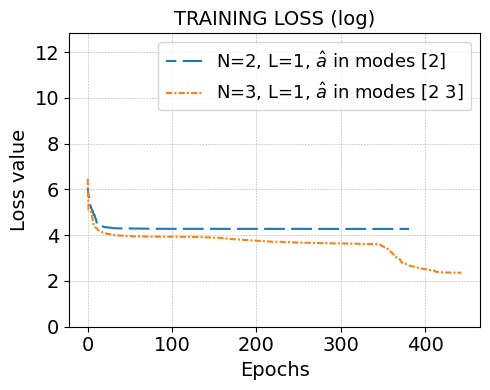

=== ACHIEVED TRAINING LOSSES ===
N=2, L=1, $\hat a$ in modes [2]: 70.8887701087003
N=3, L=1, $\hat a$ in modes [2 3]: 9.59855212795247


In [8]:
nongauss_ops = [r"$\hat a^\dagger$" if is_addition else r"$\hat a$" for is_addition in qnns_is_addition]

filename = (
    task_name
    + "_N" + str(qnns_modes)
    + "_L" + str(qnns_layers)
    + "_ph" + str(nongauss_ops)
    + str(qnns_ladder_modes)
)

plot_qnns_loglosses(train_losses, None, legend_labels, filename)


## Next steps

- Add a validation dataset and track generalization.
- Increase expressivity by adding layers or changing ladder-mode patterns.
- Try different `gamma` values and compare learnability.
